In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from carpy.aerodynamics.aerofoil import NewAerofoil
from carpy.aerodynamics.wing import WingSection, WingSections, PrandtlLLT, HorseshoeVortex

# Lift slope: Helmbold equation

In [3]:
def liftslope_helmbold(AR):
    """Liftslope of a wing as aspect ratio increases."""
    a0 = 2 * np.pi
    factor = 2 / AR 
    
    a_wing = a0 / ((1 + factor ** 2) ** 0.5 + factor)
    
    return a_wing

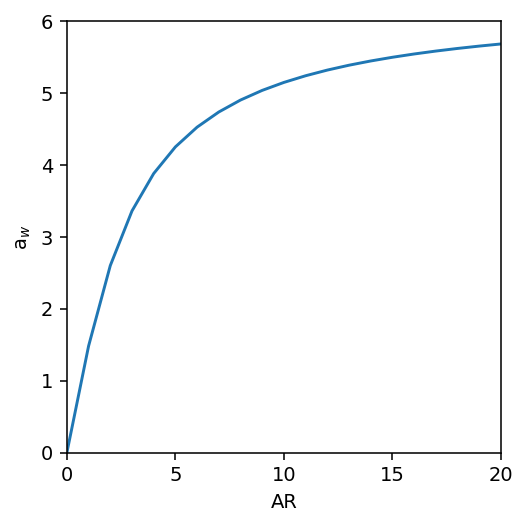

In [4]:
# Generate data
ARs = np.linspace(0, 20, 21)
aws_helmbold = liftslope_helmbold(ARs)

# Make plot
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 4))
ax.plot(ARs, aws_helmbold)
ax.set_xlabel("AR")
ax.set_ylabel("a$_w$")
ax.set_xlim(0, 20)
ax.set_ylim(0, 6)
plt.show()

# Induced Drag Factor: Horseshoe Vortex Model

In [5]:
# New aerofoil
n0012 = NewAerofoil.from_method.NACA("0012")

flightconds = {"alpha":np.radians(1), "altitude":0, "TAS":0}

In [6]:
# New wing definition
def createwing(span):
    wing = WingSections(b=span)
    wing[0] = WingSection(n0012)
    wing[1] = WingSection(n0012)

    wing[:].sweep = 0
    wing[:].dihedral = 0
    return wing


# Generate data
delta_horseshoe = []
for i, AR in enumerate(ARs):
    print(f"\r ARs[{i}] = {AR}", end="")
    if AR == 0:
        delta_horseshoe.append(0)
    else:
        solution = HorseshoeVortex(wingsections=createwing(span=AR), **flightconds)
        spaneff = solution.CL**2 / np.pi / AR / solution.CDi
        delta = 1 / spaneff - 1
        delta_horseshoe.append(delta)

 ARs[20] = 20.0

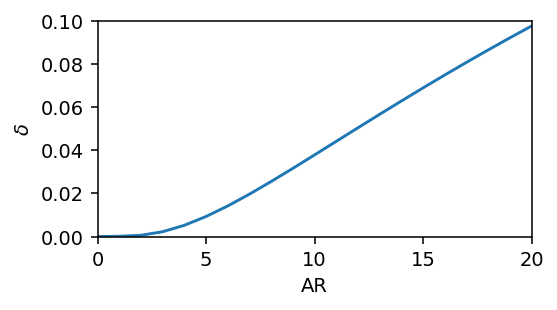

In [7]:
# Make plot
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 2))
ax.plot(ARs, delta_horseshoe)
ax.set_xlabel("AR")
ax.set_ylabel("$\delta$")
ax.set_xlim(0, 20)
ax.set_ylim(0, 0.1)
plt.show() 

## Effect of taper

In [10]:
# New wing definition
def createwing(taperratio):
    
    # Straight tapered wing, with no LE sweep
    Croot = 2 / (1 + taperratio)
    Ctip = Croot * taperratio
    SMC = 0.5 * (Croot + Ctip)
    b = AR * SMC
    
    wing = WingSections(b=b)
    wing[0] = WingSection(n0012)
    wing[1] = WingSection(n0012)

    wing[:].sweep = 0
    wing[:].dihedral = 0
    
    wing[0].chord = Croot
    wing[1].chord = Ctip
    
    return wing


# Generate data
taperratios = np.linspace(0, 1, 21)
delta_ftaper = {2: [], 6:[], 18: []}

for i, (AR, _) in enumerate(delta_ftaper.items()):
    for j, taperratio in enumerate(taperratios):
        print(f"\r {AR=:.2f}, taperratios[{j}] = {taperratio:.3f}", end="\t")

        wing = createwing(taperratio)
        
        solution = HorseshoeVortex(wingsections=wing, **flightconds)
        spaneff = solution.CL**2 / np.pi / AR / solution.CDi
        delta = 1 / spaneff - 1
        delta_ftaper[AR].append(delta)

 AR=18.00, taperratios[20] = 1.000	

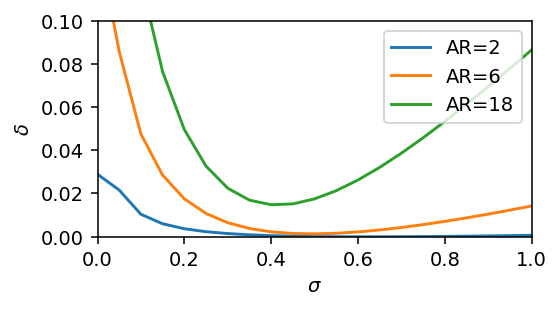

In [11]:
# Make plot
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 2))

for (AR, deltas) in delta_ftaper.items():
    ax.plot(taperratios, deltas, label=f"{AR=:.0f}")
ax.set_xlabel("$\sigma$")
ax.set_ylabel("$\delta$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.1)
ax.legend(loc="upper right")
plt.show() 

## Effect of twist

In [13]:
# New wing definition
def createwing(taperratio, twist):
    
    # Straight tapered wing, with no LE sweep
    Croot = 2 / (1 + taperratio)
    Ctip = Croot * taperratio
    SMC = 0.5 * (Croot + Ctip)
    b = AR * SMC
    
    wing = WingSections(b=b)
    wing[0] = WingSection(n0012)
    wing[1] = WingSection(n0012)

    wing[:].sweep = 0
    wing[:].dihedral = 0
    
    wing[0].chord = Croot
    wing[1].chord = Ctip
    wing[1].twist = np.radians(twist)
    
    return wing

# Generate data
delta_ftwist = {-1: [], 0: [], 1: []}
AR = 6

for i, (twist, _) in enumerate(delta_ftwist.items()):
    for j, taperratio in enumerate(taperratios):
        print(f"\r {twist=:.2f}, taperratios[{j}] = {taperratio:.3f}", end="\t")
        
        wing = createwing(taperratio, twist)

        solution = HorseshoeVortex(wingsections=wing, **flightconds)
        spaneff = solution.CL**2 / np.pi / AR / solution.CDi
        delta = 1 / spaneff - 1
        delta_ftwist[twist].append(delta)

 twist=1.00, taperratios[20] = 1.000		

Positive twist == washin (AoA at tip is greater than root)

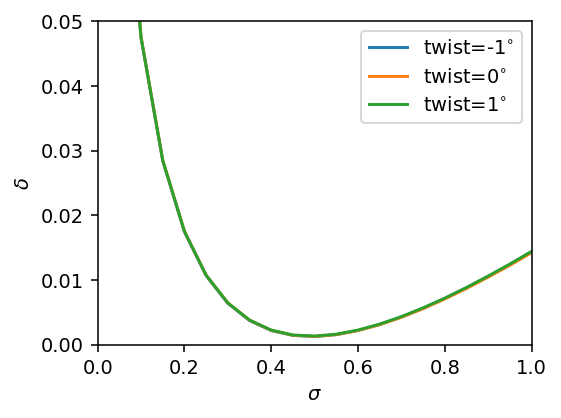

In [14]:
# Make plot
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 3))

for (twist, deltas) in delta_ftwist.items():
    ax.plot(taperratios, deltas, label=f"{twist=:.0f}"+"$^{\circ}$")
ax.set_xlabel("$\sigma$")
ax.set_ylabel("$\delta$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.05)
ax.legend(loc="upper right")
plt.show() 

## Effect of sweep

In [15]:
# New wing definition
def createwing(AR, sweep):
    wing = WingSections(b=AR)
    wing[0] = WingSection(n0012)
    wing[1] = WingSection(n0012)

    wing[:].sweep = 0
    wing[:].dihedral = 0
    # Swept rectangular wing
    wing[:].sweep = np.radians(sweep)
    return wing

# Generate data
sweepangles = np.linspace(-60, 60, 21)
delta_fsweep = {2: [], 6:[], 18: []}

wing[0].chord = 1
wing[1].chord = 1

for i, (AR, _) in enumerate(delta_fsweep.items()):
    for j, sweep in enumerate(sweepangles):
        print(f"\r {AR=:.2f}, sweepangles[{j}] = {sweep:.3f} [deg] ", end="\t")

        wing = createwing(AR, sweep)

        solution = HorseshoeVortex(wingsections=wing, **flightconds)
        spaneff = solution.CL**2 / np.pi / AR / solution.CDi
        delta = 1 / spaneff - 1
        delta_fsweep[AR].append(delta)

 AR=18.00, sweepangles[20] = 60.000 [deg] 	

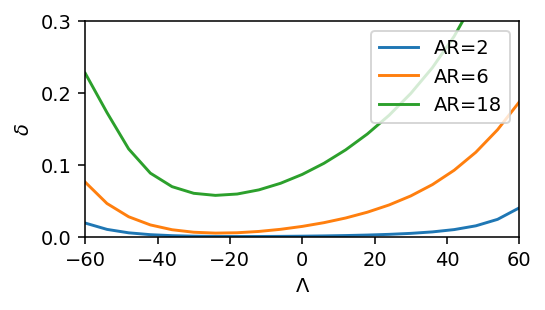

In [16]:
# Make plot
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 2))

for (AR, deltas) in delta_fsweep.items():
    ax.plot(sweepangles, deltas, label=f"{AR=:.0f}")
ax.set_xlabel("$\Lambda$")
ax.set_ylabel("$\delta$")
ax.set_xlim(-60, 60)
ax.set_ylim(0, 0.3)
ax.legend(loc="upper right")
plt.show() 